#  GLM
## [Scientific Computing with Python]


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.warnings.simplefilter('ignore', FutureWarning)
import numpy as np
import statsmodels.api as sm
import urllib.request
import zipfile
import os.path
import pandas as pd
import seaborn as sns
sns.set_context('notebook')
sns.set_palette('muted')
red, blue, green = sns.color_palette('Set1', 3)

# General instructions

1. When instructed to implement a function, use the given function names and parameters lists; failure to do so may cause test functions to fail during grading.
1. When instructed to generate a plot, make sure that the plot is clear, that axes are propely labeled, and that the notebook is saved with the plot inline, so that the grader can see the plot without running the code. Make sure that you re-generate the plot if you changed the code!
1. Code lines with a triple comment `###` should not be removed or modified, they are used for automatic grading.
1. Note that there are 3 exercises and the last cell in the notebook says **end of assignment**; if you are missing anything please download the origianl file from the course website.
1. This exercise doesn't put much emphasis on efficieny or runtime. *But*, your code should still run within a reasonable time (a few minutes) and you should use idioms learned in class, e.g. array opreations, wherever possible to "lose your loops".
1. Questions regarding the exercises should be posted to the course forum at the designated group (i.e. "assignment3"). You can post questions anonymously. You can also visit the Office Hours, but please do not email the course staff with questions about the exercise.


# Exercise 1

Following is dataset with the number of times a cricket chirps in one minute ($y$) at different temperatures $x$, in degrees Fahrenheit.

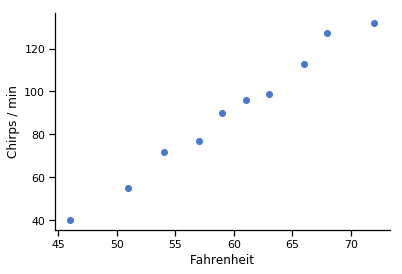

In [4]:
x = np.array([46, 51, 54, 57, 59, 61, 63, 66, 68, 72])
y = np.array([ 40,  55,  72,  77,  90,  96,  99, 113, 127, 132])

plt.plot(x, y, 'o')
plt.xlabel("Fahrenheit")
plt.ylabel("Chirps / min")
sns.despine()

**Use _statsmodels_ to fit a linear model to the data.**

Think: Which generalized linear model should you fit to the data?

**Print a summary of the model fit and plot the model prediction line over the data points.**

In [5]:
X = sm.add_constant(x) # for intercept
result_poi = sm.GLM(y, X, family=sm.families.Poisson()).fit()
print(result_poi.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   10
Model:                            GLM   Df Residuals:                        8
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -33.518
Date:                Wed, 28 Nov 2018   Deviance:                       4.2067
Time:                        09:06:38   Pearson chi2:                     4.13
No. Iterations:                     4   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8934      0.288      6.578      0.000       1.329       2.458
x1             0.0428      0.005      9.295      0.0

In [6]:
b, a = result_poi.params ###
print('a={:.4f}, b={:.2f}'.format(a, b)) ###

a=0.0428, b=1.89


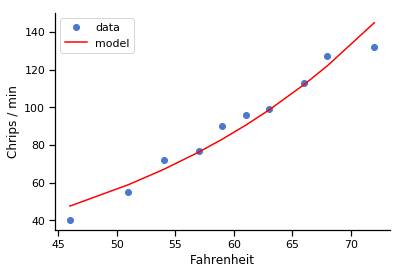

In [7]:

yhat = np.exp(b + a*x)
plt.xlabel('Fahrenheit') 
plt.ylabel('Chrips / min') 
plt.plot(x, y , 'o', label = 'data')
plt.plot(x, yhat , '-r', label = 'model')
plt.legend()
sns.despine()

# Exercise 2

Since we only have two model parameters $a$ and $b$, we can actually plot the likelihood as a function of the model parameters, which can be illuminating.

**Implement the log-likelihood of the model as a `loglik(a, b)` function.** The function uses the global `x` and `y` variables for convenience.

Think: what is the link function between $ax+b$ and $\widehat{y}$? What is the distribution of $y$ given $\widehat{y}$? How does that relate to the likelihood function? 

Tip: you can compare the results of the `loglik` function to the `result_poi.model.loglike` function of the statsmodels model you fit in Ex 1 (you don't have to if you don't want to).

In [8]:
from scipy.stats import poisson
def loglik(a, b): ###
    yhat = np.exp(a*x+b)
    poisson1 = poisson(yhat)
    log_likelyhood = poisson1.logpmf(y).sum()
    return log_likelyhood
print(loglik(a,b))
    


-33.51841611704884


**Compute the log-likelihood for a range for $a$ and $b$ values around the values found in Ex 1.** Make sure `arange` and `brange` have many values so that the plot below will look good; but you can start with a few values and when it works well go to many values.

Save the ranges of $a$ and $b$ values in arrays `arange` and `brange`, and the computed log-likelihoods in an array called `ll`.
You're `ll` variable should be a 2D array with one row for each $a$ value and one column for each $b$ value.

Bonus points: see if you can do this without Python loops using broadcasting (you'll probably need to modify `loglik`).

In [9]:
arange = np.arange(-1,1,0.03)#TODO
brange = np.arange(-5,5,0.08)#TODO
ll = np.transpose(np.array([np.vectorize(loglik)(arange,b) for b in brange]))

The next cell uses the arrays you calculated in the previous cell.
If you get something a bit different, that may be because you have a slightly different log-likelihood function, but that might not be a mistake (although it may be...).

You can see that the value we found above for $a$ and $b$ (marked by the black circle) is on a ridge of the likelihood plane, but it seems like we can increase $b$ and decrease $a$ without losing much likelihood.
This is the kind of insight we can get from a likelihood plot.

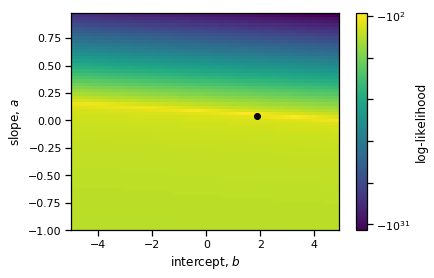

In [10]:
# don't change this cell
plt.pcolormesh(brange.squeeze(), arange.squeeze(), ll, norm=mpl.colors.SymLogNorm(1e-5))
plt.plot(b, a, 'ok') 
plt.xlabel('intercept, $b$') 
plt.ylabel('slope, $a$') 
plt.colorbar(label='log-likelihood', ticks=-np.logspace(2, 31, 6)); 

Now **implement the `gradient` function which computes the gradients of `loglik` with respect to $a$ and $b$.**

You can check your implementation of the gradient function using the `gradient_check` function and the loop below it. `gradient_check` uses your `gradient` function and compares it to an estimate of the gradient computed using a simple numerical approximation.
`gradient_check` only has output if it finds a big relative error between `gradient` and the numerical gradient; if it only has a few outputs with small errors, you are probably fine.

In [11]:
def gradient(a, b): ###
    m=len(x)
    da = (-x*np.exp(a*x+b)+x*y).sum()
    db = (y-np.exp(a*x+b)).sum()
    return (da,db)
gradient(a, b) ###

(-4.274625098332763e-11, -6.750155989720952e-13)

In [12]:
# don't change this cell
def gradient_check(a, b, ϵ=1e-4): 
    da, db = gradient(a, b)
    
    ll_plus, ll_minus = loglik(a+ϵ, b), loglik(a-ϵ, b)
    da_ = (ll_plus - ll_minus) / (2 * ϵ)
    ll_plus, ll_minus = loglik(a, b+ϵ), loglik(a, b-ϵ)
    db_ = (ll_plus - ll_minus) / (2 * ϵ)
    rel_err_a = abs(da - da_)/da
    rel_err_b = abs(db - db_)/db
    if rel_err_a > 2*ϵ or rel_err_b > 2*ϵ:
        msg = 'a={:e}, b={:e}\na relerr={:e}, b relerr={:e}'
        print(msg.format(a, b, rel_err_a, rel_err_b))
        
gradient_check(a, b)

In [13]:
# don't change this cell
a_, b_ = 0, 0 
for _ in range(1000): 
    a_, b_ = np.random.normal(a_, 0.01), np.random.normal(b_, 0.1) 
    gradient_check(a_, b_) 

Now **use gradient descent to fit the model.**
Start from $a=0$ and $b=0$.
For the learning rate $\eta$, you would need a low number, because the gradients are very large.

Notes:
- please do not override the variables `arange, brange, a, b, ll` as we would need them for plotting in the following cells.
- you want to maximize the `loglik` function, so this is really a gradient *ascent* rather than *descent*.
- it is unlikely that you will manage to find the same $a$ and $b$ values found by statsmodels (why??), so it's fine if you stop when you get a log-likelihood value of more than, say, -30.
- don't forget to print the log-likelihood, $a$ and $b$ from time to time to see the progress of the fitting.

In [14]:
a_, b_ = 0, 0 ###
η=0.0000001
flag = True
counter=0
while (counter<1000000 and flag):
    a_ = a_+ η * gradient(a_,b_)[0]
    b_ = b_+ η * gradient(a_,b_)[1]
    counter=counter+1
    if loglik(a_,b_) > -30 :
        flag = False
    



The cell below re-plots the log-likelihood plane.
**Add a red point for the values you found**.

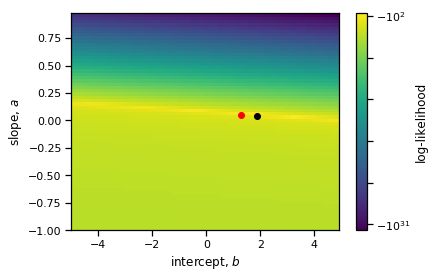

In [15]:
plt.pcolormesh(brange.squeeze(), arange.squeeze(), ll, norm=mpl.colors.SymLogNorm(1e-5)) ###
plt.plot(b, a, 'ok') ###
plt.xlabel('intercept, $b$') ###
plt.ylabel('slope, $a$') ###
plt.colorbar(label='log-likelihood', ticks=-np.logspace(2, 31, 6)); ###
plt.plot(b_, a_, 'ko', color="r") 





**Repeat the plot from the end of Ex 1, but add a line for the model you found with your own $a$ and $b$ values.**

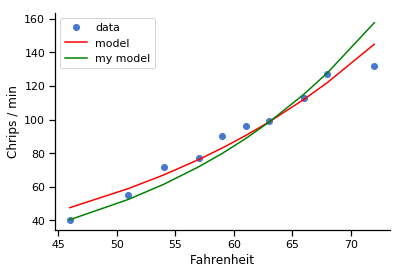

In [30]:
yhat = np.exp(b + a*x)
yhat_new_a_b = np.exp(b_ + a_*x)
plt.xlabel('Fahrenheit') 
plt.ylabel('Chrips / min') 
plt.plot(x, y , 'o', label = 'data')
plt.plot(x, yhat , '-r', label = 'model')
plt.plot(x, yhat_new_a_b, '-g', label='my model', color='green')

plt.legend()
sns.despine()





# Exercise 3

In this exercise we go back to the Tennis dataset and try to build a model that predicts if Rafael Nadal wins a game based on the number of aces and dobule faults he's made.

Start by loading the data:

In [24]:
data_url = 'https://github.com/ipython-books/cookbook-data/raw/master/tennis.zip'
data_filename = '../data/tennis.zip'
player = 'Rafael Nadal'
features = ['player1 aces', 'player1 double faults']

if not os.path.exists(data_filename):
    urllib.request.urlretrieve(data_url, data_filename)
tennis_zip = zipfile.ZipFile(data_filename)    
path = "data/{}.csv"
path = path.format(player.replace(' ', '-'))
with tennis_zip.open(path) as f:
    df = pd.read_csv(f)
df.head()

,year,tournament,start date,type,surface,draw,atp points,atp ranking,tournament prize money,round,...,player2 2nd serve return points total,player2 break points converted won,player2 break points converted total,player2 return games played,player2 total service points won,player2 total service points total,player2 total return points won,player2 total return points total,player2 total points won,player2 total points total
0,2001,"Seville, Spain",17.09.2001,CH,Outdoor: Clay,Draw: 32,5,NaN,$650,R32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2001,"Seville, Spain",17.09.2001,CH,Outdoor: Clay,Draw: 32,5,NaN,$650,R16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2001,"Spain F10, Madrid",10.09.2001,FU,Outdoor: Hard,Draw: 32,NaN,NaN,$117,R32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2002,"Spain F20, Gran Canaria",25.11.2002,FU,Outdoor: Carpet,Draw: 32,18,238.0,"$1,950",R32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2002,"Spain F20, Gran Canaria",25.11.2002,FU,Outdoor: Carpet,Draw: 32,18,238.0,"$1,950",R16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Create a column called `win` which had one if Nadal won the game and zero otherwise.**

**The remove all columns except the two features and the new target column, and drop all rows in which either of the features is unknown (`Nan`).**

In [25]:
df['win'] = np.where(df['winner']=="Rafael Nadal", 1, 0)
df = df[['player1 aces', 'player1 double faults', 'win']]
df = df.dropna()

Next, we want to split the dataset into a train set and a test set, so that we can fit the model to the train set and score the model on the test set.

To do this, **randomly choose 75% of the rows and collect them to a new dataframe called `df_train`; the rest of the rows should be in `df_test`**. You can use the `DataFrame.sample` method.

In [26]:
df_train = df.sample(frac=0.75,random_state=15)
df_test = df.drop(df_train.index)
assert df_train.shape[0] + df_test.shape[0] == df.shape[0]

Now **create `X_train`, `X_test`, `y_train`, and `y_test`** which have the required columns from the respective dataframes.

Also, consider adding a constant column to the `X_...` data frames so that you can fit the intercept.

In [27]:
X_test = df_test[["player1 double faults","player1 aces"]]
y_train = df_train["win"]
X_train = df_train[["player1 double faults","player1 aces"]]
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
y_test = df_test["win"]

Now we are ready to fit the model to the data.
**Use statsmodels `Logit` to fit a logistic model to the train data.**

In [28]:
result_logit = sm.Logit(y_train, X_train)
result_logit=result_logit.fit()
result_logit.summary() ###

Optimization terminated successfully.
         Current function value: 0.414746
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    win   No. Observations:                  513
Model:                          Logit   Df Residuals:                      510
Method:                           MLE   Df Model:                            2
Date:                Wed, 28 Nov 2018   Pseudo R-squ.:                 0.04190
Time:                        10:27:14   Log-Likelihood:                -212.76
converged:                       True   LL-Null:                       -222.07
                                        LLR p-value:                 9.093e-05
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     2.0948      0.232      9.021      0.000       1.640       2.550
player1 double faults    -0.3617      0.085     -4.239      0.000      -0.529      -0.194
player1 aces              0.0745      0.049      1.513      0.130      -0.022       0.171
=========================================================================================
"""

Finally, **compute the test accuracy of the fitted model**: predict the win probability for the games in `X_test`, use the predicted win probabilities to predict if each game was won or lost, and check for each game if your prediction was correct by comparing to `y_test`.

**Print the model test accuracy**, which is the fraction of games in the test set for which the model prediction was correct.
If you got a similar or higher accuracy then you are fine; if you got something considerably lower than you probably did something wrong.

In [29]:
prediction= result_logit.predict(X_test).round()
string = "Accuracy: {}"
string.format((prediction==y_test).mean())

'Accuracy: 0.7602339181286549'

**end of assignment**